In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

## Useful functions 

In [2]:
def count_unique(array):
    return len(set(array))

## Read Data 

In [3]:
df = pd.read_excel("Data/CaseStudy.xlsx",  engine='openpyxl')

In [4]:
# Remove Promotion Products
df = df[df["Promotion Active"]=="Not Active"]

## ACV per CITY

In [5]:
df_acv = (df
 .groupby(by =["CITY"])
 .agg(total_sales_per_city = ('Sales','sum'))
 .sort_values(by=["total_sales_per_city"], ascending=[0]))

df_acv["acv%"] = df_acv["total_sales_per_city"]*100/np.sum(df_acv.total_sales_per_city)
df_acv.reset_index(inplace=True)
df_acv["acv_per_mm"]=df_acv["total_sales_per_city"]/1e6

In [6]:
df_acv

,CITY,total_sales_per_city,acv%,acv_per_mm
0,COLUMBIA,203316322,39.967650,203.316322
1,SPRINGFIELD,169359500,33.292464,169.359500
2,JOPLIN,135971559,26.729107,135.971559
3,BILLINGS,30233,0.005943,0.030233
4,CRANE,24603,0.004836,0.024603


In [7]:
k = df_acv[["CITY","acv%"]].to_dict()

kk=dict(zip(list(k['CITY'].values()),list(k['acv%'].values())))
col = kk.keys()
per = np.array(list(kk.values()))

In [84]:
df_acv

,CITY,total_sales_per_city,acv%,acv_per_mm
0,COLUMBIA,203316322,39.967650,203.316322
1,SPRINGFIELD,169359500,33.292464,169.359500
2,JOPLIN,135971559,26.729107,135.971559
3,BILLINGS,30233,0.005943,0.030233
4,CRANE,24603,0.004836,0.024603


<AxesSubplot:title={'center':'ACV% By City'}, xlabel='CITY', ylabel='acv%'>

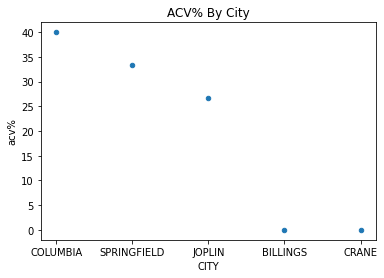

In [21]:
df_acv.plot.scatter(x="CITY",y="acv%", title="ACV% By City")

## ACV per ELEMENT_GROUP

In [67]:
df_acv_eg = (df
             .groupby(by =["ELEMENT_GROUP"])
             .agg(total_sales = ('Sales','sum'))
             .sort_values(by=["total_sales"], ascending=[0])
            )

df_acv_eg["acv%"] = df_acv_eg["total_sales"]*100/np.sum(df_acv_eg.total_sales)
df_acv_eg.reset_index(inplace=True)
df_acv_eg["acv_per_mm"]=df_acv_eg["total_sales"]/1e6

In [68]:
df_acv_eg

,ELEMENT_GROUP,total_sales,acv%,acv_per_mm
0,BEVERAGES,249842979,49.113798,249.842979
1,BABY,94676742,18.611427,94.676742
2,BAKERY,85832597,16.872857,85.832597
3,BREAKFAST,33478526,6.581164,33.478526
4,PHARMACY,25384880,4.990126,25.384880
5,CAT FOOD,19486493,3.830629,19.486493


## ACV % by Brand 

In [9]:
df_b = df[["BRAND HIGH","CITY"]].drop_duplicates()
df_b["values"]=1
df_p = df_b.pivot(index="BRAND HIGH",columns="CITY",values="values").fillna(0)
df_p["acv%"] = np.sum(df_p[col].to_numpy()*per,axis=1)
brand_acv = df_p.sort_values(by=["acv%"]).reset_index()[["BRAND HIGH","acv%"]]
brand_velocity = df.merge(brand_acv, on=["BRAND HIGH"])
bv=(brand_velocity
 .groupby(by =["CITY","ELEMENT_GROUP","ELEMENT","BRAND HIGH","acv%"])
 .agg(sku_count= ('Product SKU',count_unique), sales_sum = ('Sales','sum'))
 .sort_values(by=[ "sales_sum"], ascending=[0]))
print(bv.head())
bv = bv.reset_index()
bv["brand_sspd"]=bv["sales_sum"]/bv["acv%"]
bv_final = bv.merge(df_acv[["CITY","acv_per_mm"]],on=["CITY"])
bv_final["sales_per_million"] = bv_final["brand_sspd"]/bv_final["acv_per_mm"]



                                                       sku_count  sales_sum
CITY        ELEMENT_GROUP ELEMENT BRAND HIGH acv%                          
COLUMBIA    BEVERAGES     COFFEE  STARBUCKS  99.98922         35   13723811
SPRINGFIELD BEVERAGES     COFFEE  STARBUCKS  99.98922         35   11470030
COLUMBIA    BEVERAGES     TEA     TWININGS   99.98922         24   10834646
JOPLIN      BEVERAGES     COFFEE  STARBUCKS  99.98922         35    9798080
SPRINGFIELD BEVERAGES     TEA     TWININGS   99.98922         23    9371022


In [52]:
df.groupby("ELEMENT_GROUP").count()

,CITY,STATE,ELEMENT,BRAND HIGH,BRAND LOW,PRODUCT,BRAND_DESC_LONG,Product SKU,Price of Product,Units Sold,Sales,Number of Customers,Trips,Sales Week,Promotion Active
ELEMENT_GROUP,,,,,,,,,,,,,,,
BABY,13410,13410,13410,13410,13410,13410,13410,13410,13410,13410,13410,13410,13410,13410,13410
BAKERY,12934,12934,12934,12934,12934,12934,12934,12934,12934,12934,12934,12934,12934,12934,12934
BEVERAGES,35391,35391,35391,35391,35391,35391,35391,35391,35391,35391,35391,35391,35391,35391,35391
BREAKFAST,3813,3813,3813,3813,3813,3813,3813,3813,3813,3813,3813,3813,3813,3813,3813
CAT FOOD,2383,2383,2383,2383,2383,2383,2383,2383,2383,2383,2383,2383,2383,2383,2383
PHARMACY,3915,3915,3915,3915,3915,3915,3915,3915,3915,3915,3915,3915,3915,3915,3915


## Comparing Cities

In [10]:
bv_final[bv_final["CITY"]=="COLUMBIA"].sort_values(by="brand_sspd", ascending =[0]).head(10)

,CITY,ELEMENT_GROUP,ELEMENT,BRAND HIGH,acv%,sku_count,sales_sum,brand_sspd,acv_per_mm,sales_per_million
0,COLUMBIA,BEVERAGES,COFFEE,STARBUCKS,99.989220,35,13723811,137252.905297,203.316322,675.070766
1,COLUMBIA,BEVERAGES,TEA,TWININGS,99.989220,24,10834646,108358.140560,203.316322,532.953476
2,COLUMBIA,BABY,DIAPERS,PAMPERS,99.989220,18,6713777,67145.007955,203.316322,330.248980
3,COLUMBIA,BABY,DIAPERS,HUGGIES,99.995164,15,6192639,61929.385168,203.316322,304.596230
4,COLUMBIA,BAKERY,CAKE,CHICAGO SWEET CONNECTION BAKERY,99.989220,13,5931692,59323.314809,203.316322,291.778418
5,COLUMBIA,BEVERAGES,TEA,ARIZONA,99.989220,14,4578133,45786.265571,203.316322,225.197196
6,COLUMBIA,BABY,DIAPERS,LUVS,99.989220,12,4189635,41900.866741,203.316322,206.087078
7,COLUMBIA,CAT FOOD,DRY CAT FOOD,SOLID GOLD,99.989220,8,3322676,33230.342094,203.316322,163.441586
8,COLUMBIA,BEVERAGES,BEER,YOUNG'S,99.989220,6,3138176,31385.143189,203.316322,154.366078
9,COLUMBIA,BEVERAGES,COFFEE,WOLFGANG PUCK,99.989220,8,3006256,30065.800969,203.316322,147.876967


In [71]:
bv_final.to_csv("output.csv")

In [11]:
bv_final[bv_final["CITY"]=="SPRINGFIELD"].sort_values(by="brand_sspd", ascending =[0]).head(10)

,CITY,ELEMENT_GROUP,ELEMENT,BRAND HIGH,acv%,sku_count,sales_sum,brand_sspd,acv_per_mm,sales_per_million
310,SPRINGFIELD,BEVERAGES,COFFEE,STARBUCKS,99.989220,35,11470030,114712.665552,169.3595,677.332335
311,SPRINGFIELD,BEVERAGES,TEA,TWININGS,99.989220,23,9371022,93720.322664,169.3595,553.380960
312,SPRINGFIELD,BABY,DIAPERS,PAMPERS,99.989220,18,5502223,55028.161809,169.3595,324.919251
313,SPRINGFIELD,BABY,DIAPERS,HUGGIES,99.995164,15,5188957,51892.079721,169.3595,306.401942
314,SPRINGFIELD,BAKERY,CAKE,CHICAGO SWEET CONNECTION BAKERY,99.989220,13,5125054,51256.065192,169.3595,302.646531
315,SPRINGFIELD,BEVERAGES,TEA,ARIZONA,99.989220,14,3808664,38090.746025,169.3595,224.910596
316,SPRINGFIELD,BABY,DIAPERS,LUVS,99.989220,12,3427772,34281.415395,169.3595,202.418024
317,SPRINGFIELD,CAT FOOD,DRY CAT FOOD,SOLID GOLD,99.989220,8,2796139,27964.404447,169.3595,165.118605
318,SPRINGFIELD,BEVERAGES,BEER,SAMUEL SMITH,99.989220,6,2527050,25273.224349,169.3595,149.228265
319,SPRINGFIELD,BEVERAGES,COFFEE,WOLFGANG PUCK,99.989220,8,2468123,24683.890822,169.3595,145.748487


In [12]:
bv_final[bv_final["CITY"]=="JOPLIN"].sort_values(by="brand_sspd", ascending =[0]).head(10)

,CITY,ELEMENT_GROUP,ELEMENT,BRAND HIGH,acv%,sku_count,sales_sum,brand_sspd,acv_per_mm,sales_per_million
618,JOPLIN,BEVERAGES,COFFEE,STARBUCKS,99.989220,35,9798080,97991.363065,135.971559,720.675440
619,JOPLIN,BEVERAGES,TEA,TWININGS,99.989220,23,8245292,82461.809043,135.971559,606.463658
620,JOPLIN,BABY,DIAPERS,PAMPERS,99.989220,18,4554409,45548.999994,135.971559,334.989172
621,JOPLIN,BAKERY,CAKE,CHICAGO SWEET CONNECTION BAKERY,99.989220,13,4432791,44332.688881,135.971559,326.043837
622,JOPLIN,BABY,DIAPERS,HUGGIES,99.995164,15,4376682,43768.936852,135.971559,321.897735
623,JOPLIN,BEVERAGES,TEA,ARIZONA,99.989220,14,3247675,32480.251237,135.971559,238.875332
624,JOPLIN,BABY,DIAPERS,LUVS,99.989220,12,2835894,28361.997306,135.971559,208.587719
625,JOPLIN,BEVERAGES,BEER,SAMUEL SMITH,99.989220,6,2178840,21790.748953,135.971559,160.259610
626,JOPLIN,BEVERAGES,BEER,YOUNG'S,99.989220,5,2127022,21272.513089,135.971559,156.448255
627,JOPLIN,BEVERAGES,COFFEE,WOLFGANG PUCK,99.989220,8,2080748,20809.723202,135.971559,153.044676


In [13]:
bv_final[bv_final["CITY"]=="BILLINGS"].sort_values(by="brand_sspd", ascending =[0]).head(10)

,CITY,ELEMENT_GROUP,ELEMENT,BRAND HIGH,acv%,sku_count,sales_sum,brand_sspd,acv_per_mm,sales_per_million
926,BILLINGS,BABY,DIAPERS,FITTI,99.995164,1,10863,108.635254,0.030233,3593.267425
927,BILLINGS,BEVERAGES,BEER,LOWENBRAU,99.995164,1,9248,92.484473,0.030233,3059.057088
928,BILLINGS,BABY,DIAPERS,HUGGIES,99.995164,1,5586,55.862702,0.030233,1847.739283
929,BILLINGS,BEVERAGES,BEER,TECATE,99.995164,1,4536,45.362194,0.030233,1500.419869


In [74]:
bv_final[bv_final["CITY"]=="CRANE"].sort_values(by="brand_sspd", ascending =[0]).head(10)

,CITY,ELEMENT_GROUP,ELEMENT,BRAND HIGH,acv%,sku_count,sales_sum,brand_sspd,acv_per_mm,sales_per_million
930,CRANE,BEVERAGES,BEER,GREENE KING,99.994057,1,8778,87.785217,0.024603,3568.069635
931,CRANE,BEVERAGES,BEER,NEGRA MODELO,99.994057,1,5040,50.402996,0.024603,2048.652422
932,CRANE,BEVERAGES,BEER,CURRAHEE BREWING COMPANY,99.994057,1,3850,38.502288,0.024603,1564.942822
933,CRANE,BEVERAGES,BEER,MODELO,99.994057,1,3560,35.602116,0.024603,1447.064012
934,CRANE,BEVERAGES,COFFEE,JAVA HOUSE,99.994057,1,3375,33.752006,0.024603,1371.865461


In [76]:
bv_final["rank"] = bv_final.groupby(["CITY","ELEMENT_GROUP"])["sales_per_million"].rank(ascending=False)

In [83]:
bv_final.head(50)

,CITY,ELEMENT_GROUP,ELEMENT,BRAND HIGH,acv%,sku_count,sales_sum,brand_sspd,acv_per_mm,sales_per_million,rank
0,COLUMBIA,BEVERAGES,COFFEE,STARBUCKS,99.989220,35,13723811,137252.905297,203.316322,675.070766,1.0
1,COLUMBIA,BEVERAGES,TEA,TWININGS,99.989220,24,10834646,108358.140560,203.316322,532.953476,2.0
2,COLUMBIA,BABY,DIAPERS,PAMPERS,99.989220,18,6713777,67145.007955,203.316322,330.248980,1.0
3,COLUMBIA,BABY,DIAPERS,HUGGIES,99.995164,15,6192639,61929.385168,203.316322,304.596230,2.0
4,COLUMBIA,BAKERY,CAKE,CHICAGO SWEET CONNECTION BAKERY,99.989220,13,5931692,59323.314809,203.316322,291.778418,1.0
5,COLUMBIA,BEVERAGES,TEA,ARIZONA,99.989220,14,4578133,45786.265571,203.316322,225.197196,3.0
6,COLUMBIA,BABY,DIAPERS,LUVS,99.989220,12,4189635,41900.866741,203.316322,206.087078,3.0
7,COLUMBIA,CAT FOOD,DRY CAT FOOD,SOLID GOLD,99.989220,8,3322676,33230.342094,203.316322,163.441586,1.0
8,COLUMBIA,BEVERAGES,BEER,YOUNG'S,99.989220,6,3138176,31385.143189,203.316322,154.366078,4.0
9,COLUMBIA,BEVERAGES,COFFEE,WOLFGANG PUCK,99.989220,8,3006256,30065.800969,203.316322,147.876967,5.0


[]

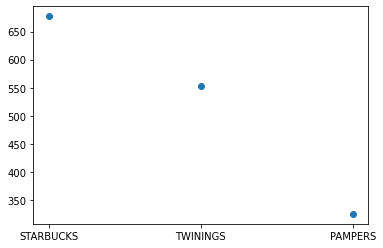

In [48]:
plt.scatter(y= bv_final[bv_final["CITY"]=="SPRINGFIELD"].head(3)["sales_per_million"],
            x = bv_final[bv_final["CITY"]=="SPRINGFIELD"].head(3)["BRAND HIGH"] 
           )

plt.plot()

## ACV by ELEMENT GROUPS

In [56]:
df_b = df[["BRAND HIGH","ELEMENT_GROUP"]].drop_duplicates()
df_b["values"]=1
df_p = df_b.pivot(index="BRAND HIGH",columns="ELEMENT_GROUP",values="values").fillna(0)
# df_p["acv%"] = np.sum(df_p[col].to_numpy()*per,axis=1)
# brand_acv = df_p.sort_values(by=["acv%"]).reset_index()[["BRAND HIGH","acv%"]]
# brand_velocity = df.merge(brand_acv, on=["BRAND HIGH"])
# bv=(brand_velocity
#  .groupby(by =["CITY","ELEMENT_GROUP","ELEMENT","BRAND HIGH","acv%"])
#  .agg(sku_count= ('Product SKU',count_unique), sales_sum = ('Sales','sum'))
#  .sort_values(by=[ "sales_sum"], ascending=[0]))
# print(bv.head())
# bv = bv.reset_index()
# bv["brand_sspd"]=bv["sales_sum"]/bv["acv%"]
# bv_final = bv.merge(df_acv[["CITY","acv_per_mm"]],on=["CITY"])
# bv_final["sales_per_million"] = bv_final["brand_sspd"]/bv_final["acv_per_mm"]



In [57]:
df_p

ELEMENT_GROUP,BABY,BAKERY,BEVERAGES,BREAKFAST,CAT FOOD,PHARMACY
BRAND HIGH,,,,,,
ACE,0.0,0.0,1.0,0.0,0.0,0.0
ALASKAN,0.0,0.0,1.0,0.0,0.0,0.0
ALAVERT,0.0,0.0,0.0,0.0,0.0,1.0
ALE SMITH,0.0,0.0,1.0,0.0,0.0,0.0
ALL GOOD,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
WONDER DRYS,1.0,0.0,0.0,0.0,0.0,0.0
WORLD CLASS BAKERY,0.0,1.0,0.0,0.0,0.0,0.0
WRIGHT,0.0,0.0,0.0,1.0,0.0,0.0


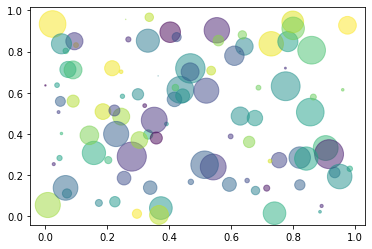

In [27]:
N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()